In [1]:
# Imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/test-and-training-data/train.csv")

In [3]:
df.head()


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [4]:
# Check correlations with the target
correlations = df.corr()['BeatsPerMinute'].sort_values(ascending=False)
print(correlations)

BeatsPerMinute               1.000000
MoodScore                    0.007059
TrackDurationMs              0.006637
RhythmScore                  0.005440
VocalContent                 0.004876
LivePerformanceLikelihood    0.003471
InstrumentalScore            0.001900
id                          -0.000355
AcousticQuality             -0.000820
AudioLoudness               -0.003327
Energy                      -0.004375
Name: BeatsPerMinute, dtype: float64


In [5]:
# Features and target 
# Drop target + id columns
X_raw = df.drop(columns=['BeatsPerMinute', 'id'])
y = df['BeatsPerMinute']

print (X_raw.shape)

(524164, 9)


In [6]:
#Drop low-variance features
selector = VarianceThreshold(threshold=0.01)
X_filtered = pd.DataFrame(
    selector.fit_transform(X_raw),
    columns=X_raw.columns[selector.get_support()]
)
print (X_filtered.shape)

(524164, 8)


In [7]:
# Feature engineering: Convert TrackDurationMs from milliseconds to seconds
if 'TrackDurationMs' in X_raw.columns:
    X_raw['TrackDurationMs'] = X_raw['TrackDurationMs'] / 1000.0
    


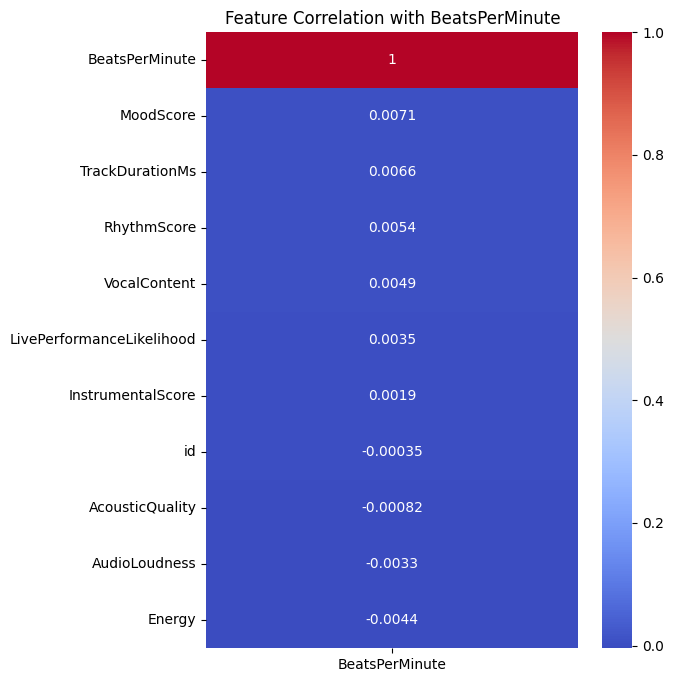

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(6,8))
sns.heatmap(corr[['BeatsPerMinute']].sort_values(by='BeatsPerMinute', ascending=False),
            cmap="coolwarm", annot=True)
plt.title("Feature Correlation with BeatsPerMinute")
plt.show()



In [9]:
# Train/Test split
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42
)

In [10]:
# Linear Regression 
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_val)
rmse_lin = mean_squared_error(y_val, y_pred_lin, squared=False)
print("Linear Regression RMSE:", rmse_lin)


Linear Regression RMSE: 26.443196155162173


In [11]:
# Ridge Regression 
ridge = make_pipeline(StandardScaler(), Ridge(alpha=10))
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_val)
rmse_ridge = mean_squared_error(y_val, y_pred_ridge, squared=False)
print("Ridge Regression RMSE:", rmse_ridge)

Ridge Regression RMSE: 26.443196157831427


In [12]:
# Random Forest 
rf = RandomForestRegressor(
    n_estimators=100, max_depth=10, max_features='sqrt',
    random_state=42, n_jobs=2
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
print("Random Forest RMSE:", rmse_rf)

Random Forest RMSE: 26.438234545113545


In [13]:
# Baseline (mean predictor) 
baseline_pred = np.full_like(y_val, y_train.mean())
rmse_baseline = mean_squared_error(y_val, baseline_pred, squared=False)
print("Baseline RMSE:", rmse_baseline)

Baseline RMSE: 26.445357100903113


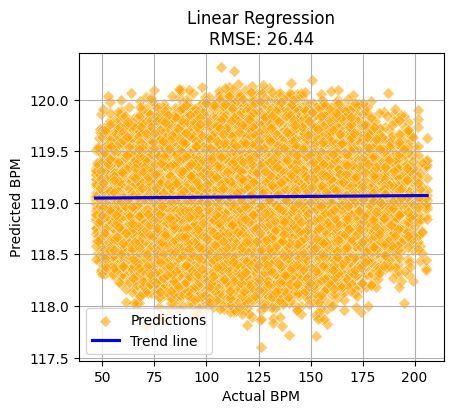

In [14]:
# Linear Regression Plot
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
sns.scatterplot(x=y_val, y=y_pred_lin, color='orange', marker='D', alpha=0.6, label="Predictions")
sns.regplot(x=y_val, y=y_pred_lin, scatter=False, color='blue', label="Trend line")
plt.title(f"Linear Regression\nRMSE: {rmse_lin:.2f}")
plt.xlabel("Actual BPM"); plt.ylabel("Predicted BPM"); plt.legend(); plt.grid(True)

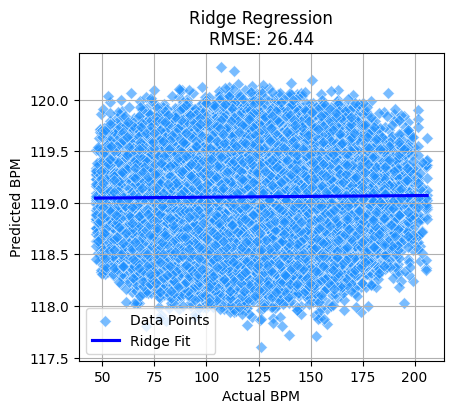

In [15]:
# Ridge Regression Plot
plt.figure(figsize=(16,4))

plt.subplot(1,3,2)
sns.scatterplot(x=y_val, y=y_pred_ridge, color='dodgerblue', marker='D', alpha=0.6, label="Data Points")
sns.regplot(x=y_val, y=y_pred_ridge, scatter=False, color='blue', label="Ridge Fit")
plt.title(f"Ridge Regression\nRMSE: {rmse_ridge:.2f}")
plt.xlabel("Actual BPM"); plt.ylabel("Predicted BPM"); plt.legend(); plt.grid(True)

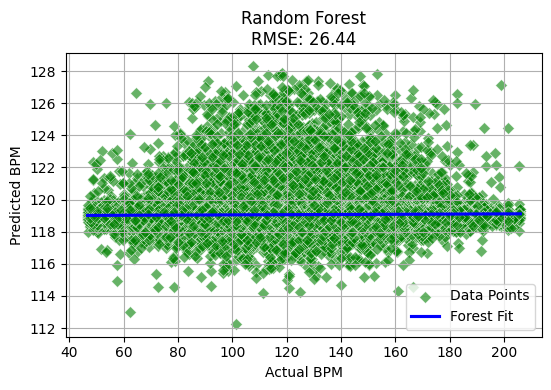

In [16]:
# Random Forest Plot
plt.figure(figsize=(16,4))

plt.subplot(1,3,3)
sns.scatterplot(x=y_val, y=y_pred_rf, color='green', marker='D', alpha=0.6, label="Data Points")
sns.regplot(x=y_val, y=y_pred_rf, scatter=False, color='blue', label="Forest Fit")
plt.title(f"Random Forest\nRMSE: {rmse_rf:.2f}")
plt.xlabel("Actual BPM"); plt.ylabel("Predicted BPM"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
# Show prefomance metrics, rmse 
metrics = {
    "Baseline": rmse_baseline,
    "Linear Regression": rmse_lin,
    "Ridge Regression": rmse_ridge,
    "Random Forest": rmse_rf
}
print(pd.DataFrame(metrics, index=["RMSE"]).T)

                        RMSE
Baseline           26.445357
Linear Regression  26.443196
Ridge Regression   26.443196
Random Forest      26.438235


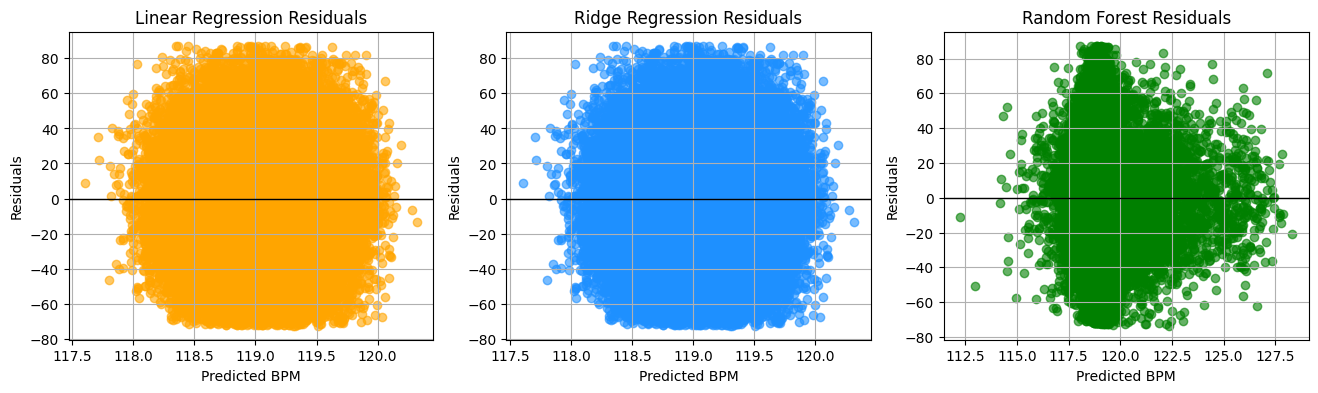

In [18]:
# Residual plots 
plt.figure(figsize=(16,4))

# Linear Regression residuals
plt.subplot(1,3,1)
resid_lin = y_val - y_pred_lin
plt.scatter(y_pred_lin, resid_lin, color='orange', alpha=0.6)
plt.axhline(0, color='black', linewidth=1)
plt.title("Linear Regression Residuals")
plt.xlabel("Predicted BPM"); plt.ylabel("Residuals"); plt.grid(True)

# Ridge Regression residuals
plt.subplot(1,3,2)
resid_ridge = y_val - y_pred_ridge
plt.scatter(y_pred_ridge, resid_ridge, color='dodgerblue', alpha=0.6)
plt.axhline(0, color='black', linewidth=1)
plt.title("Ridge Regression Residuals")
plt.xlabel("Predicted BPM"); plt.ylabel("Residuals"); plt.grid(True)

# Random Forest residuals
plt.subplot(1,3,3)
resid_rf = y_val - y_pred_rf
plt.scatter(y_pred_rf, resid_rf, color='green', alpha=0.6)
plt.axhline(0, color='black', linewidth=1)
plt.title("Random Forest Residuals")
plt.xlabel("Predicted BPM"); plt.ylabel("Residuals"); plt.grid(True)

In [19]:
# Kaggle submission
test_df = pd.read_csv("/kaggle/input/test-and-training-data/test.csv")

# Drop id column
X_test_raw = test_df.drop(columns=['id'])

# Convert TrackDurationMs to seconds
if 'TrackDurationMs' in X_test_raw.columns:
    X_test_raw['TrackDurationMs'] = X_test_raw['TrackDurationMs'] / 1000.0

# Apply the same VarianceThreshold selector used during training
X_test_filtered = pd.DataFrame(
    selector.transform(X_test_raw),
    columns=X_raw.columns[selector.get_support()]
)

# Predict with the trained Random Forest
y_test_pred = rf.predict(X_test_filtered)

# Build submission DataFrame
submission = pd.DataFrame({
    "id": test_df["id"],
    "BeatsPerMinute": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("Submission file created. Preview:")
print(submission.head())


Submission file created. Preview:
       id  BeatsPerMinute
0  524164      118.946720
1  524165      119.315232
2  524166      118.902674
3  524167      117.494517
4  524168      119.048272
